## 加载数据

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
trainData = pd.read_csv('./data/train_set.csv')
testData  = pd.read_csv('./data/test_set.csv')
trainDataLen = len(trainData)
testDataLen = len(testData)
print(trainDataLen)
print(testDataLen)

data = pd.concat([trainData, testData], sort = False)

25317
10852


In [3]:
# 查看数据信息
print(data.head())

   ID  age         job   marital  education default  balance housing loan  \
0   1   43  management   married   tertiary      no      291     yes   no   
1   2   42  technician  divorced    primary      no     5076     yes   no   
2   3   47      admin.   married  secondary      no      104     yes  yes   
3   4   28  management    single  secondary      no     -994     yes  yes   
4   5   42  technician  divorced  secondary      no     2974     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome    y  
0   unknown    9   may       150         2     -1         0  unknown  0.0  
1  cellular    7   apr        99         1    251         2    other  0.0  
2  cellular   14   jul        77         2     -1         0  unknown  0.0  
3  cellular   18   jul       174         2     -1         0  unknown  0.0  
4   unknown   21   may       187         5     -1         0  unknown  0.0  


In [4]:
# 只包含数值型信息?
print(data.describe())

                ID           age        balance           day      duration  \
count  36169.00000  36169.000000   36169.000000  36169.000000  36169.000000   
mean   18085.00000     40.966961    1368.237026     15.788742    257.574497   
std    10441.23528     10.639679    3098.876172      8.314523    255.040668   
min        1.00000     18.000000   -8019.000000      1.000000      0.000000   
25%     9043.00000     33.000000      73.000000      8.000000    103.000000   
50%    18085.00000     39.000000     449.000000     16.000000    181.000000   
75%    27127.00000     48.000000    1437.000000     21.000000    318.000000   
max    36169.00000     95.000000  102127.000000     31.000000   3881.000000   

           campaign         pdays      previous             y  
count  36169.000000  36169.000000  36169.000000  25317.000000  
mean       2.771545     40.160552      0.578147      0.116957  
std        3.114445    100.005886      2.365582      0.321375  
min        1.000000     -1.00000

In [5]:
# 查看数据信息
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36169 entries, 0 to 10851
Data columns (total 18 columns):
ID           36169 non-null int64
age          36169 non-null int64
job          36169 non-null object
marital      36169 non-null object
education    36169 non-null object
default      36169 non-null object
balance      36169 non-null int64
housing      36169 non-null object
loan         36169 non-null object
contact      36169 non-null object
day          36169 non-null int64
month        36169 non-null object
duration     36169 non-null int64
campaign     36169 non-null int64
pdays        36169 non-null int64
previous     36169 non-null int64
poutcome     36169 non-null object
y            25317 non-null float64
dtypes: float64(1), int64(8), object(9)
memory usage: 5.2+ MB
None


In [6]:
# 查看所有object的枚举类型
# 帅选出object类型
def objectInfoView(data):
    columnObjects = data.columns[data.dtypes=="object"]
    dic = {}
    for object in columnObjects:
        dic[object] = data[object].unique()
    return dic

In [7]:
print(objectInfoView(data))

{'job': array(['management', 'technician', 'admin.', 'services', 'retired',
       'student', 'blue-collar', 'unknown', 'entrepreneur', 'housemaid',
       'self-employed', 'unemployed'], dtype=object), 'marital': array(['married', 'divorced', 'single'], dtype=object), 'education': array(['tertiary', 'primary', 'secondary', 'unknown'], dtype=object), 'default': array(['no', 'yes'], dtype=object), 'housing': array(['yes', 'no'], dtype=object), 'loan': array(['no', 'yes'], dtype=object), 'contact': array(['unknown', 'cellular', 'telephone'], dtype=object), 'month': array(['may', 'apr', 'jul', 'jun', 'nov', 'aug', 'jan', 'feb', 'dec',
       'oct', 'sep', 'mar'], dtype=object), 'poutcome': array(['unknown', 'other', 'failure', 'success'], dtype=object)}


## 数据预处理

| NO |  字段名称 | 数据类型 |                             字段描述                            |
|:--:|:---------:|:--------:|:---------------------------------------------------------------:|
|  1 |     ID    |    Int   |                           客户唯一标识                          |
|  2 |    age    |    Int   |                             客户年龄                            |
|  3 |    job    |  String  |                            客户的职业                           |
|  4 |  marital  |  String  |                             婚姻状况                            |
|  5 | education |  String  |                            受教育水平                           |
|  6 |  default  |  String  |                          是否有违约记录                         |
|  7 |  balance  |    Int   |                        每年账户的平均余额                       |
|  8 |  housing  |  String  |                          是否有住房贷款                         |
|  9 |    loan   |  String  |                          是否有个人贷款                         |
| 10 |  contact  |  String  |                       与客户联系的沟通方式                      |
| 11 |    day    |    Int   |                    最后一次联系的时间（几号）                   |
| 12 |   month   |  String  |                    最后一次联系的时间（月份）                   |
| 13 |  duration |    Int   |                      最后一次联系的交流时长                     |
| 14 |  campaign |    Int   |                在本次活动中，与该客户交流过的次数               |
| 15 |   pdays   |    Int   | 距离上次活动最后一次联系该客户，过去了多久（999表示没有联系过） |
| 16 |  previous |    Int   |               在本次活动之前，与该客户交流过的次数              |
| 17 |  poutcome |  String  |                         上一次活动的结果                        |
| 18 |     y     |    Int   |                  预测客户是否会订购定期存款业务                 |

**对于文本类型的数据**
- job: 管理, 技术, 服务, 学生等。 对于未知的应该怎么处理?
- education: 高等教育, 中等教育, 初级教育, 未知。 对于未知的数据要怎么处理?
- contact: 沟通方式, 网络, 电话和未知。
- poutcome: 上一次活动的结果, 未知, 其他, 失败和成功。 未知怎么处理?

**对于数值类型的数据**
-  ID: 做删除处理
-  pdays: 999代表为联系过, -1代表刚联系过? 

In [8]:
# 删除id， 同时删除上一次联系的日期, 此数据与 pdays 重复, 且为文本型数据, 不宜处理。
print(data.columns)
noIdData = data.drop(['ID','day','month'],axis = 1)
print(noIdData.head())

Index(['ID', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')
   age         job   marital  education default  balance housing loan  \
0   43  management   married   tertiary      no      291     yes   no   
1   42  technician  divorced    primary      no     5076     yes   no   
2   47      admin.   married  secondary      no      104     yes  yes   
3   28  management    single  secondary      no     -994     yes  yes   
4   42  technician  divorced  secondary      no     2974     yes   no   

    contact  duration  campaign  pdays  previous poutcome    y  
0   unknown       150         2     -1         0  unknown  0.0  
1  cellular        99         1    251         2    other  0.0  
2  cellular        77         2     -1         0  unknown  0.0  
3  cellular       174         2     -1         0  unknown  0.0  
4   unknown       

In [9]:
# 把类别量装换为指示变量(one-hot encoding)
columnNames = noIdData.columns[noIdData.dtypes=="object"]
dummy = pd.get_dummies(noIdData[columnNames])
print(dummy.head())

   job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0           0                0                 0              0   
1           0                0                 0              0   
2           1                0                 0              0   
3           0                0                 0              0   
4           0                0                 0              0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0               1            0                  0             0            0   
1               0            0                  0             0            0   
2               0            0                  0             0            0   
3               1            0                  0             0            0   
4               0            0                  0             0            0   

   job_technician  ...  housing_yes  loan_no  loan_yes  contact_cellular  \
0               0  ...            1     

In [10]:
# 查看数据范围, 都是0-1, 把每个变量的每个属性作为一个单独的变量。
for column in dummy.columns:
    print(column, dummy[column].unique())

job_admin. [0 1]
job_blue-collar [0 1]
job_entrepreneur [0 1]
job_housemaid [0 1]
job_management [1 0]
job_retired [0 1]
job_self-employed [0 1]
job_services [0 1]
job_student [0 1]
job_technician [0 1]
job_unemployed [0 1]
job_unknown [0 1]
marital_divorced [0 1]
marital_married [1 0]
marital_single [0 1]
education_primary [0 1]
education_secondary [0 1]
education_tertiary [1 0]
education_unknown [0 1]
default_no [1 0]
default_yes [0 1]
housing_no [0 1]
housing_yes [1 0]
loan_no [1 0]
loan_yes [0 1]
contact_cellular [0 1]
contact_telephone [0 1]
contact_unknown [1 0]
poutcome_failure [0 1]
poutcome_other [0 1]
poutcome_success [0 1]
poutcome_unknown [1 0]


In [11]:
columnNames = noIdData.columns[noIdData.dtypes=="object"]
noIdData.drop(columnNames, inplace=True, axis=1)
train = pd.concat([dummy, noIdData], axis=1)
print(train.head())

   job_admin.  job_blue-collar  job_entrepreneur  job_housemaid  \
0           0                0                 0              0   
1           0                0                 0              0   
2           1                0                 0              0   
3           0                0                 0              0   
4           0                0                 0              0   

   job_management  job_retired  job_self-employed  job_services  job_student  \
0               1            0                  0             0            0   
1               0            0                  0             0            0   
2               0            0                  0             0            0   
3               1            0                  0             0            0   
4               0            0                  0             0            0   

   job_technician  ...  poutcome_other  poutcome_success  poutcome_unknown  \
0               0  ...               0

## 划分数据集

In [12]:
X1 = train[train.columns[:-1]][:trainDataLen]
y1 = train['y'][:trainDataLen]
xTrain, xTest, yTrain, yTest = train_test_split(X1, y1, test_size=0.3,random_state=88)

## 算法模型搭建
### 随机森林算法

0.9015860238669078 91


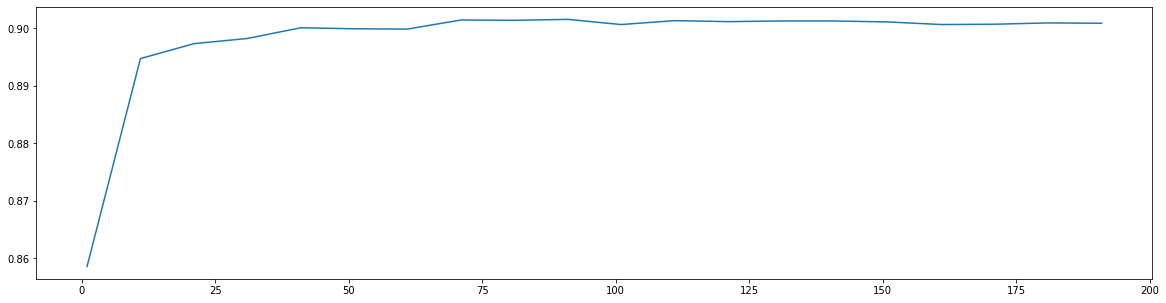

In [13]:
# 先评估参数
scorel = []
for i in range(0,200,10):      #从[0,200)只取能被10整除的数
    rfc = RandomForestClassifier(n_estimators=i+1,   #森林里（决策）树的数目。
                                 n_jobs=-1, # 
                                 random_state=90)
    score = cross_val_score(rfc,xTrain,yTrain,cv=10).mean()    #过传入的模型，训练十次，最后将十次结果求平均值。将每个数据集都算一次
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
plt.plot(range(1,201,10),scorel)
plt.show()

### 确认参数建立模型

In [14]:
rfc = RandomForestClassifier(n_estimators=91, random_state=88)
rfc.fit(xTrain, yTrain)
print(rfc.score(xTest, yTest))

0.8992890995260664


## 输出比赛结果

In [15]:
X2 = train[train.columns[:-1]][trainDataLen:]
pred = rfc.predict_proba(X2)
resultData = pd.DataFrame(pred, index=testData['ID'], columns=['pred0', 'pred'])
resultData.drop('pred0', axis=1, inplace=True)
resultData.to_csv('result.csv')